# Network model using graphical lasso based on extended BIC criterium

The example below demonstrates network analysis on radiomic features employing partial correlation-based graphical lasso.

This code reads radiomics features and outputs two files: (1) partial correlations among features and (2) preprocessed radiomic features by removing those highly correlated with tumor volume.

Please note that the code was wriiten using R.


**Citation:** Oh et al, SU-400-360, AAPM 2023 and Oh et al, Journal of Medical Imaging, 8(3):031904, 2021

In [ ]:
radiomics_csv_file = 'radiomic_data.csv'
EBICgraph_file = "EBICgraph.csv"
preprocessed_radiomics_file = "preprocessed_data_red.csv"

In [1]:
# Install packages
install.packages("igraph")
install.packages("Matrix")
install.packages("qgraph")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
library("qgraph")
library("igraph")
library("Matrix")


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [4]:
# Read radiomic data
data_raw <- read.csv(radiomics_csv_file,header=T)
id <- data_raw[,1]
no_col <- ncol(data_raw)
data <- data_raw[,2:no_col]
m <- length(data) # number of features
variables <- colnames(data) # feature names



In [5]:
# Remove features that are highly correlated with the tumor volume
vol_name <- 'Shape_volume' # name of the volume feature
vol_idx <- which(colnames(data)==vol_name) # index of the volume feature
vol <- data[,vol_idx]
COR_VOl_THRESH <- 0.8 # Spearman correlation threshold
cor_vol <- numeric(m)

for (i in 1:m){
  spear_cor <- cor(vol, data[,i], method = "spearman")
  cor_vol[i] <- spear_cor
}
ind <- which(abs(cor_vol)  < COR_VOl_THRESH)
ind <- c(vol_idx,ind) # add the index of volume feature

# Extract a subset of features
data_red <- data[,ind]
m_red <- length(data_red)
variables_red <- variables[ind]


In [6]:
# Normalization of features with negative values for unbalanced OMT
data_red_nor <- data_red
ind1 <- c()
for (i in 1:m_red){
  if (min(data_red[,i]) < 0){
    ind1 <- c(ind1,i)
    x <- data_red[,i]
    nor_x <- (x-min(x))/(max(x)-min(x))
    data_red_nor[,i] <- nor_x
  }
}

In [7]:
# To ensure the matrix is positive definite
cormatrix <- cor(data_red,method='pearson')
cor_PD <- nearPD(cormatrix,corr=TRUE)
CorMat <- as.matrix(cor_PD$mat)

# EBIC LASSO (partial correlation-based graphical LASSO)
EBICgraph <- EBICglasso(CorMat, nrow(data_red), 0.5, threshold = TRUE)


Warning message in log(det(K)):
“NaNs produced”
Warning message in log(det(K)):
“NaNs produced”


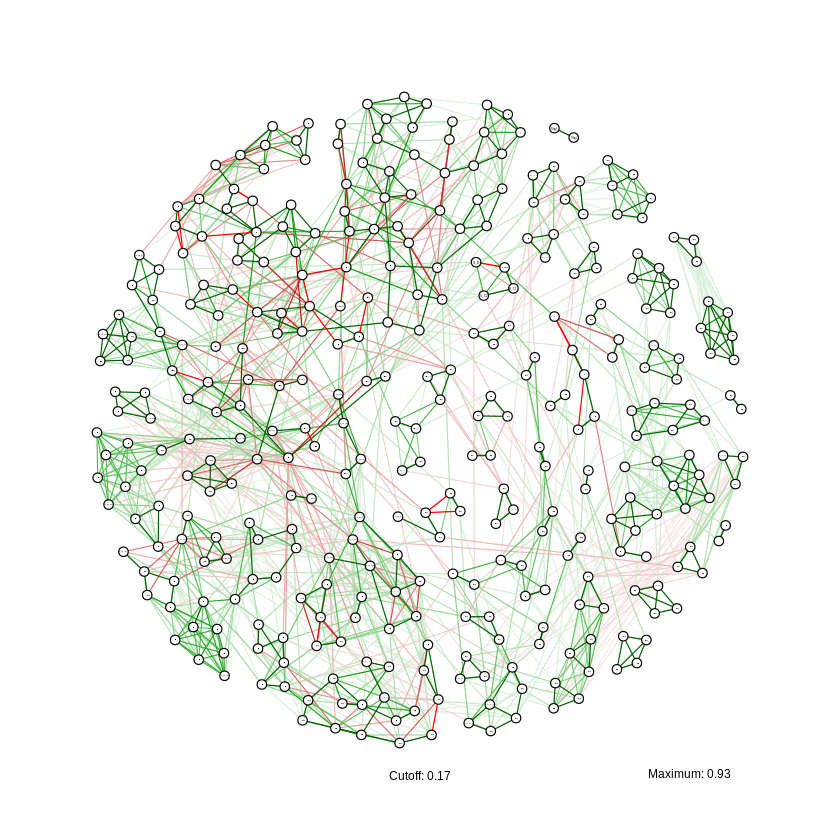

In [8]:
# Plot the resulting network,
# For qgraph, refer to https://cran.r-project.org/web/packages/qgraph/qgraph.pdf
graph <- qgraph(EBICgraph, layout = "spring", details = TRUE)
g <- as.igraph(graph, attributes=TRUE)
gg <- as.undirected(g)
com <- components(gg, mode = c("weak", "strong"))

In [9]:
# Save EBIC results and data
write.csv(EBICgraph, file = EBICgraph_file, row.names = variables_red)
write.csv(cbind(id, data_red_nor), file = preprocessed_radiomics_file, row.names = FALSE)
